In [ ]:
# Do not edit. These are the only imports permitted.
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

In [ ]:
class MAB(ABC):

    @abstractmethod
    def play(self, tround, context):
        # Current round of t (for my implementations average mean reward array
        # at round t is passed to this function instead of tround itself)
        self.tround = tround
        # Context: features of contextual bandits
        self.context = context
        # choose an arm which yields maximum value of average mean reward, tie breaking randomly
        chosen_arm = np.random.choice(np.where(self.tround==max(self.tround))[0])
        return chosen_arm
        pass


    @abstractmethod
    def update(self, arm, reward, context):
        # get the chosen arm
        self.arm = arm
        # get the context (may be None)
        self.context = context
        # update the overall step of the model
        self.step_n += 1
        # update the step of individual arms
        self.step_arm[self.arm] += 1
        # update average mean reward of each arm
        self.AM_reward[self.arm] = ((self.step_arm[self.arm] - 1) / float(self.step_arm[self.arm])
        * self.AM_reward[self.arm] + (1 / float(self.step_arm[self.arm])) * reward)
        return
        pass

In [ ]:
def offlineEvaluate(mab, arms, rewards, contexts, nrounds=None):
    # array to contain chosen arms in offline mode
    chosen_arms = np.zeros(nrounds)
    # rewards of each chosen arm
    reward_arms = np.zeros(nrounds)
    # cumulative reward at each iteration
    cumulative_reward = np.zeros(nrounds)
    # initialize tround to zero
    T = 0
    # initialize overall cumulative reward to zero
    G = 0
    # History or memory of offline evaluator
    history = []
    # play once and get the initial action
    action = mab.play(T, contexts[0,:])[0]
    cumulative_q = []
    cumulative_contexts = []
    #===============================
    #    MAIN LOOP ...
    #===============================
    for i in range(np.shape(data)[0]):
        # print(mab.play(T, contexts[i,:])[0])
        action =  mab.play(T, contexts[i,:])[0]
               # time_contexts.append(np.array(mab.play(T, contexts[i,:])[2]))
        if T<nrounds:
          # print(mab.play(T, contexts[i,:])[2])
            # q.append(np.array(mab.play(T, contexts[i,:])[1]))
            # update parameters and play only when chosen arm from bandit matches data
            if action == arms[i]:
                # append the current context of chosen arm to the previous history (list)
                history.append(contexts[i,:])
                # get the reward of chosen arm at round T
                reward_arms[T] = rewards[i]
                # the returned action is between 1-10, setting to python encoding ==> 0-9
                mab.update(action-1, rewards[i], contexts[i,:])
                # update overall cumulative reward
                G += rewards[i]
                # print(G)
                # update cumulative reward of round T
                cumulative_reward[T] = G
                # store chosen arm at round T
                chosen_arms[T] = action
                # for i in range(10):
                cumulative_q.append(np.array(mab.play(T, contexts[i,:])[1]))
                # print(len(time_contexts[0]))
                # cumulative_q.append(q)
                cumulative_contexts.append(np.array(mab.play(T, contexts[i,:])[2]))
                T +=1
        else:
            # if desired tround ends, terminate the loop
            break
    return reward_arms, chosen_arms, cumulative_reward, history, np.array(cumulative_q), np.array(cumulative_contexts)

In [ ]:
# load dataset and initialize arms, rewards and contexts arrays
data = np.loadtxt('./dataset.txt')
arms = data[:,0]
rewards = data[:,1]
contexts = data[:,2:102]
# mab = EpsGreedy(10, 0.05)
# results_EpsGreedy, chosen_arms_EpsGreedy, cumulative_reward_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
# print('EpsGreedy average reward', np.mean(results_EpsGreedy))

In [ ]:
class LinUCB(MAB):

    def __init__(self, narms, ndims, alpha):
        # Set number of arms
        self.narms = narms
        # Number of context features
        self.ndims = ndims
        # explore-exploit parameter
        self.alpha = alpha
        # Instantiate A as a ndims×ndims matrix for each arm
        self.A = np.zeros((self.narms, self.ndims, self.ndims))
        # Instantiate b as a 0 vector of length ndims.
        self.b = np.zeros((narms, self.ndims, 1))
        # set each A per arm as identity matrix of size ndims
        for arm in range(self.narms):
            self.A[arm] = np.eye(self.ndims)

        super().__init__()
        return

    def play(self, tround, context):
        # gains per each arm
        p_t = np.zeros(self.ndims)
        q_t = np.zeros(self.ndims)
        arm_context = []
        #===============================
        #    MAIN LOOP ...
        #===============================
        for i in range(self.ndims):
            # initialize theta hat
            self.theta = inv(self.A[i]).dot(self.b[i])
            # get context of each arm from flattened vector of length 100
            cntx = context[i*10:(i+1)*10]
            arm_context.append(cntx)
            q_t[i] = self.alpha * np.sqrt(
            cntx.dot(inv(self.A[i]).dot(cntx)))
            # get gain reward of each arm
            p_t[i] = self.theta.T.dot(cntx
                ) + q_t[i]
        action = np.random.choice(np.where(p_t==max(p_t))[0])
        # print(len(arm_context[0]))
        # np.argmax returns values 0-9, we want to compare with arm indices in dataset which are 1-10
        # Hence, add 1 to action before returning
        return action+1, q_t, np.array(arm_context)


    def update(self, arm, reward, context):
        self.A[arm] = self.A[arm] + np.outer(context[arm*10:(arm+1)*10],context[arm*10:(arm+1)*10])
        self.b[arm] = np.add(self.b[arm].T, context[arm*10:(arm+1)*10]*reward).reshape(self.ndims,1)
        return

In [ ]:
mab = LinUCB(10, 10, 1.0)
# results_LinUCB, chosen_arms_LinUCB, cumulative_reward_LinUCB, contexts_LinUCB, q, contexts = offlineEvaluate(mab, arms, rewards, contexts, 800)
# print('LinUCB average reward', np.mean(results_LinUCB))
results_LinUCB, chosen_arms_LinUCB, cumulative_reward_LinUCB, contexts_LinUCB, q, cumulative_contexts_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))
print()

<ipython-input-47-28407af192c4>:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p_t[i] = self.theta.T.dot(cntx


LinUCB average reward 0.53



<ipython-input-47-28407af192c4>:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p_t[i] = self.theta.T.dot(cntx


LinUCB average reward 0.53


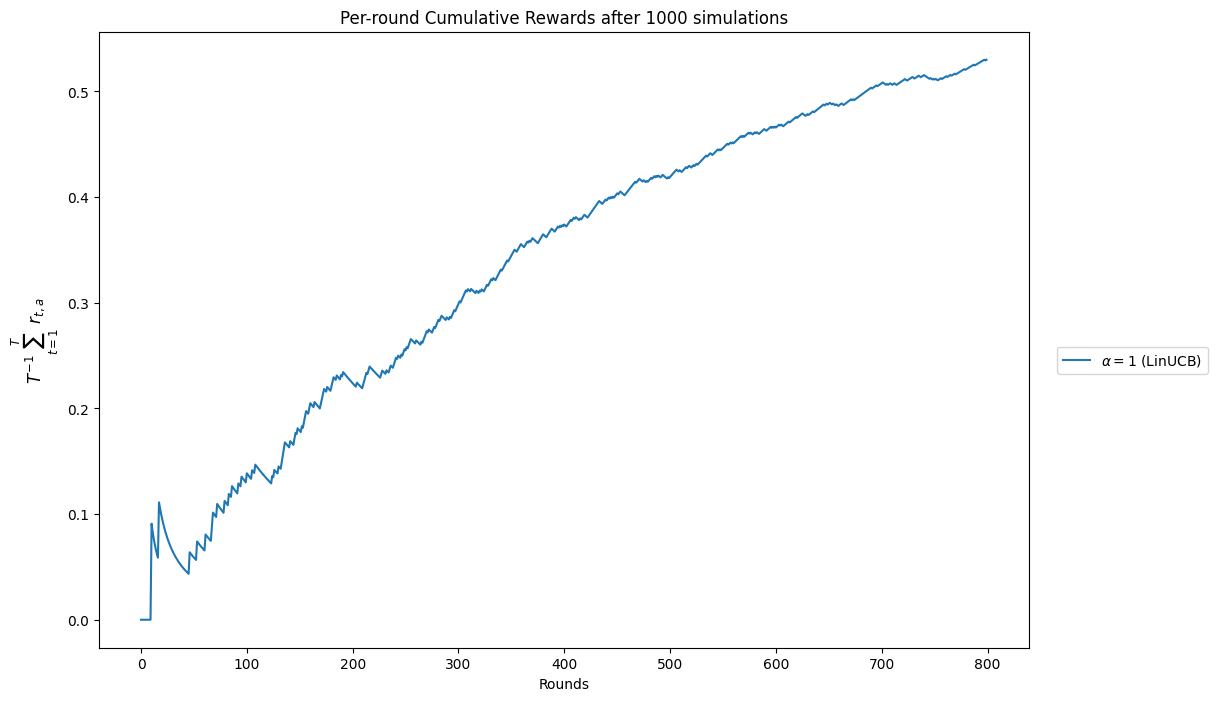

In [ ]:
#===============================
#    Linear UCB (Contextual) ...
#===============================
mab = LinUCB(10, 10, 1.0)
results_LinUCB, chosen_arms_LinUCB, cumulative_reward_LinUCB, history, q, contexts_3 = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

#===============================
#    Plotting results ...
#===============================

plt.figure(figsize=(12,8))
plt.plot(cumulative_reward_LinUCB/np.linspace(1,800,800), label = r"$\alpha=1$ (LinUCB)")
# plt.plot(mean_UCB/(1000*np.linspace(1,800,800)), label = r"$\rho=1$ (UCB)")
# plt.plot(mean_EPSgreedy/(1000*np.linspace(1,800,800)), label = r"$\epsilon=0.05$ (greedy)")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Rounds")
plt.ylabel(r"$T^{-1}\sum_{t=1}^T\ r_{t,a}$", fontsize='large')
plt.title("Per-round Cumulative Rewards after 1000 simulations")
plt.show()

<ipython-input-47-28407af192c4>:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p_t[i] = self.theta.T.dot(cntx


Mean reward of LinUCB with alpha = 0.02 is:  0.73125
Mean reward of LinUCB with alpha = 0.06 is:  0.70625
Mean reward of LinUCB with alpha = 0.176 is:  0.6225


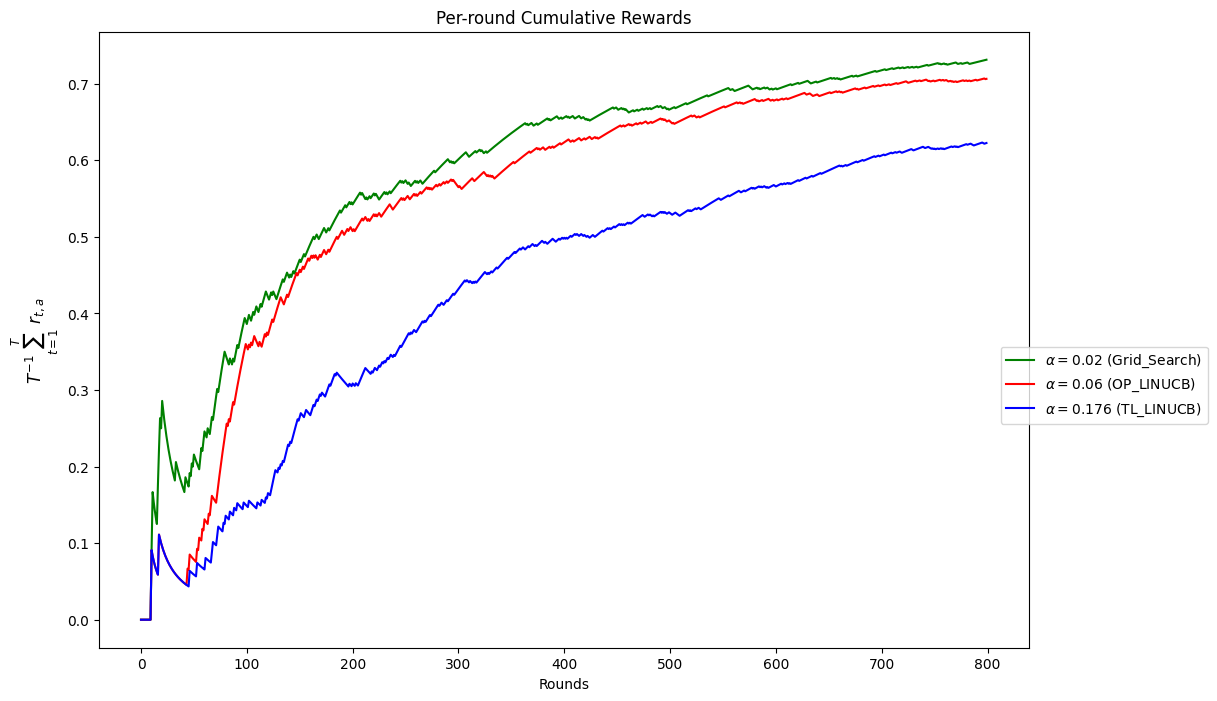

In [ ]:
# build LinUCB with alpha = 0.02
mab = LinUCB(10, 10, 0.02)
results_LinUCB_02, chosen_arms_LinUCB_02, cumulative_reward_LinUCB_02, history_02, q_02, contexts_02 = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('Mean reward of LinUCB with alpha = 0.02 is: ', np.mean(results_LinUCB_02))

# build LinUCB with alpha = 1
mab = LinUCB(10, 10, 0.0596)
results_LinUCB_1, chosen_arms_LinUCB_1, cumulative_reward_LinUCB_1, history_1, q_1, contexts_1 = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('Mean reward of LinUCB with alpha = 0.06 is: ', np.mean(results_LinUCB_1))

mab = LinUCB(10, 10, 0.5)
results_LinUCB_3, chosen_arms_LinUCB_3, cumulative_reward_LinUCB_3, history_3, q_3, contexts_3 = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('Mean reward of LinUCB with alpha = 0.176 is: ', np.mean(results_LinUCB_3))

# #===============================
# #    Plotting results ...
# #===============================

plt.figure(figsize=(12,8))
plt.plot(cumulative_reward_LinUCB_02/np.linspace(1,800,800), 'g', label = r"$\alpha=0.02$ (Grid_Search)")
plt.plot(cumulative_reward_LinUCB_1/np.linspace(1,800,800), 'r', label = r"$\alpha=0.06$ (OP_LINUCB)")
plt.plot(cumulative_reward_LinUCB_3/np.linspace(1,800,800), 'b', label = r"$\alpha=0.176$ (TL_LINUCB)")
# plt.plot(mean_UCB/(1000*np.linspace(1,800,800)), label = r"$\rho=1$ (UCB)")
# plt.plot(mean_EPSgreedy/(1000*np.linspace(1,800,800)), label = r"$\epsilon=0.05$ (greedy)")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Rounds")
plt.ylabel(r"$T^{-1}\sum_{t=1}^T\ r_{t,a}$", fontsize='large')
plt.title("Per-round Cumulative Rewards")
plt.show()

In [ ]:
results_LinUCB_02, chosen_arms_LinUCB_02, cumulative_reward_LinUCB_02, history_02, q_02, cumulative_contexts_02 = offlineEvaluate(mab, arms, rewards, contexts, 800)

<ipython-input-47-28407af192c4>:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p_t[i] = self.theta.T.dot(cntx


In [ ]:
# @title Default title text
def inverse_bandit_linucb(T, num_actions, context_dim, alpha, context_sequence, arm_sequence, qs, learning_method, update_interval, update_rate, cumulative_contexts):  #As = forward_algo.lin_ucb()[1]
    # Initialize variables
    w = 10  # size of the moving time window
    theta_hat = np.zeros((T, context_dim))  # Initialize theta_hat as a matrix to store values at each time step
    M_list = []  # List to store matrices Mi
    b_list = []  # List to store vectors bi
    cumulative_theta = np.zeros((T, context_dim))
    j = 0
    # Main loop over time steps
    a_i_ = np.array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0])
    for t in range(T):
        # Add current context and arm to sequences
        a_t = np.array(arm_sequence[t])
        # print(a_t)
        # print(a_t) -- working
        # q_x_at = qs[t]
        # print(q_x_at) -- working
        # M_t = np.zeros((1, context_dim))
        # b_t = np.zeros((num_actions - 1))
        M_t = []
        b_t = []
        #for i in range(num_actions):
        a_i = []
        x_ai = []
        x_at = []
        q_x_ai = []
        for i in range(num_actions):
          if a_i_[i] == a_t:
            x_at = context_sequence[t][i*10:(i+1)*10]
            q_x_at = qs[t][i]
          if a_i_[i] != a_t:
            a_i.append(a_i_[i])
            x_ai.append(np.array(context_sequence[t][i*10:(i+1)*10]))
            q_x_ai.append(qs[t][i])

        # print(x_ai[0].size)
        # x_ai = np.array([cumulative_contexts[i] for i in range(num_actions) if a_i[i] != a_t])
        # print(x_ai)
        a_i = np.array(a_i)
        x_ai = np.array(x_ai)

        # q_x_ai = np.array([qs[i] for i in range(num_actions) if i != a_t])
        # print('q_x_ai-',len(q_x_ai))
        # print('q_x_at-',q_x_at)
        # print(alpha*(q_x_at - q_x_ai[0]))
        # print(q_x_at.shape)
        for j in range(len(x_ai)):
          M_t.append(np.array((x_ai[j] - x_at)))
          b_t.append(np.array(q_x_at - q_x_ai[j]))
        # M_t = np.array([(x_ai[j] - x_at) for j in range(x_ai.size)])
        # b_t = alpha * (q_x_at - q_x_ai)         # Calculate the LinUCB features for the chosen arm
        if len(M_list) == w:
            M_list.pop(0)
            b_list.pop(0)
        M_list.append(M_t)
        b_list.append(b_t)
        # print('b_t[0]-', b_t[0])


        # Update theta at regular intervals
        if t % update_interval == 0 and t >= w:
            # Construct the matrices M and vector b for the optimization problem
            M = np.vstack(M_list)
            b = np.concatenate(b_list)
            # print('M-',M.shape)
            # print('b-',b.shape)

            # Solve the linear system of equations using the inverse of D
            D = M @ M.T
            # print(D)
            # print('D', D.shape)
            if np.linalg.matrix_rank(D) == context_dim:
                D_inv = np.linalg.pinv(D)
                # print(D_inv.shape, b.shape)
                lambda_values = D_inv @ (2 * b)
                # print('lambda-', lambda_values.shape)
                new_theta = 0.5 * M.T @ lambda_values
                # print(M.shape)
                # Update theta as a linear combination of previous and new theta
                theta_hat[t] = update_rate * theta_hat[t - update_interval] + (1 - update_rate) * new_theta
                # print(theta_hat[t])
                # print(theta_hat.shape)
                cumulative_theta[t] = cumulative_theta[t - 1] + theta_hat[t]


                  # print(cumulative_theta)

                # print(x)



            # # Update the inverse matrix A_inv in the learning method
            # for M_i in M_list[-w:]:
            #     for x_i in M_i:
            #         learning_method.update_A_inv(x_i)

        # print(theta_hat)
        # else:
        #   print("hi")
        # else:
        #   print("hi")

    return theta_hat, cumulative_theta

# Example usage
T = 800  # total number of time steps
#beta = 0.5  # parameter in the LinUCB method
update_interval = 1  # update theta every 10 time steps
update_rate = 0.5  # linear combination rate for updating theta
forward_algorithm = LinUCB(10, 10, 0.02)
# Generate synthetic data for the forward agent (A)
#context_sequence = forward_algorithm.evaluate_policy()[2]
# print(context_sequence)
#arm_sequence = forward_algorithm.best()[1]
# print(arm_sequence)

# Create an instance of the learning method
# linucb_learning_method = LearningMethod(d, alpha)
num_actions = 10
context_dim = 10
alpha = 0.02
best_contexts = history_02
q_values =  q_02
best_arms = chosen_arms_LinUCB_02
cumulative = cumulative_contexts_02
# Run the inverse bandit algorithm
estimated_theta, cumulative_theta = inverse_bandit_linucb(T, num_actions, context_dim, alpha, best_contexts, best_arms, q_values, forward_algorithm, update_interval, update_rate, cumulative)
print(len(estimated_theta))
print(estimated_theta)

800
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.00101663 -0.00193256 -0.00588638 ... -0.00297587 -0.00032697
  -0.00473546]
 [ 0.00093034 -0.00099986 -0.00832671 ... -0.0040695   0.00048307
  -0.00420724]
 [ 0.00127627 -0.00123147 -0.0080977  ... -0.00720406  0.0018021
  -0.00467654]]


In [ ]:
linucb1 = LinUCB(10, 10, 0.059)
linucb2 = LinUCB(10, 10, 0.02)
linucb3 = LinUCB(10, 10, 0.176)
results_LINUCB1, chosen_arms_LINUCB1, cumulative_reward_LINUCB1, history_LINUCB1, cumulative_q_LINUCB1, cumulative_contexts_LINUCB1 = offlineEvaluate(linucb1, arms, rewards, contexts, 800)
results_LinUCB2, chosen_arms_LinUCB2, cumulative_reward_LinUCB2, history_LINUCB2, cumulative_q_LINUCB2, cumulative_contexts_LINUCB2 = offlineEvaluate(linucb2, arms, rewards, contexts, 800)
results_LinUCB3, chosen_arms_LinUCB3, cumulative_reward_LinUCB3, history_LINUCB3, cumulative_q_LINUCB3, cumulative_contexts_LINUCB3 = offlineEvaluate(linucb3, arms, rewards, contexts, 800)

<ipython-input-47-28407af192c4>:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p_t[i] = self.theta.T.dot(cntx


In [ ]:
# Example usage
T = 800  # total number of time steps
#beta = 0.5  # parameter in the LinUCB method
update_interval = 1  # update theta every 10 time steps
update_rate = 0.5  # linear combination rate for updating theta
# Generate synthetic data for the forward agent (A)
#context_sequence = forward_algorithm.evaluate_policy()[2]
# print(context_sequence)
#arm_sequence = forward_algorithm.best()[1]
# print(arm_sequence)

# Create an instance of the learning method
# linucb_learning_method = LearningMethod(d, alpha)
num_actions = 10
context_dim = 10
best_contexts1 = history_LINUCB1
q_values1 =  cumulative_q_LINUCB1
best_arms1 = chosen_arms_LINUCB1
cumulative1 = cumulative_contexts_LINUCB1
# Run the inverse bandit algorithm
estimated_theta1, cumulative_theta1 = inverse_bandit_linucb(T, num_actions, context_dim, 0.09, best_contexts1, best_arms1, q_values1, linucb1, update_interval, update_rate, cumulative1)
print(len(estimated_theta1))
print(estimated_theta1)
best_contexts2 = history_LINUCB2
q_values2 =  cumulative_q_LINUCB2
best_arms2 = chosen_arms_LinUCB2
cumulative2 = cumulative_contexts_LINUCB2
estimated_theta2, cumulative_theta2 = inverse_bandit_linucb(T, num_actions, context_dim, 0.02, best_contexts2, best_arms2, q_values2, linucb2, update_interval, update_rate, cumulative2)
print(len(estimated_theta2))
print(estimated_theta2)

800
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [-0.00012342 -0.00033808 -0.00307986 ... -0.00097153  0.00069062
  -0.00104172]
 [-0.00014639 -0.00036388 -0.00314272 ... -0.00119195  0.00077005
  -0.00094019]
 [-0.00020033 -0.00011914 -0.00361212 ... -0.00123921  0.0009178
  -0.00078172]]
800
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [-3.62555648e-05 -1.83777446e-04 -1.53964528e-03 ... -1.01622388e-03
   6.24008002e-04 -4.14974219e-04]
 [-3.94884939e-05 -3.27035386e-04 -1.42042586e-03 ... -8.93014705e-04
   5.88117503e-04 -4.02596984e

In [ ]:
# linucb3 = LinUCB(10, 10, 0.5)
# results_LINUCB3, chosen_arms_LINUCB3, cumulative_reward_LINUCB3, history_LINUCB3, cumulative_q_LINUCB3, cumulative_contexts_LINUCB3 = offlineEvaluate(linucb3, arms, rewards, contexts, 800)
best_contexts3 = history_LINUCB3
q_values3 =  cumulative_q_LINUCB3
best_arms3 = chosen_arms_LINUCB3
cumulative3 = cumulative_contexts_LINUCB3
estimated_theta3, cumulative_theta3 = inverse_bandit_linucb(T, num_actions, context_dim, 1.01, best_contexts2, best_arms2, q_values2, linucb2, update_interval, update_rate, cumulative2)
print(len(estimated_theta3))
print(estimated_theta3)

800
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [-3.62555648e-05 -1.83777446e-04 -1.53964528e-03 ... -1.01622388e-03
   6.24008002e-04 -4.14974219e-04]
 [-3.94884939e-05 -3.27035386e-04 -1.42042586e-03 ... -8.93014705e-04
   5.88117503e-04 -4.02596984e-04]
 [-5.21861871e-05 -3.93796962e-04 -1.36649536e-03 ... -6.71516188e-04
   5.93509685e-04 -3.86050855e-04]]


In [ ]:
# Assuming 'mab' is your LinUCB instance
combined_A1 = np.zeros((mab.ndims, mab.ndims))
combined_b1 = np.zeros((mab.ndims, 1))

# Combine A and b matrices from all arms
for arm in range(linucb1.narms):
    combined_A1 += linucb1.A[arm]
    combined_b1 += linucb1.b[arm]

# Estimate the shared theta using the combined A and b matrices
shared_theta_estimate1 = np.linalg.inv(combined_A1).dot(combined_b1)

# Print the estimated shared theta
print("Estimated Shared Theta:")
print(shared_theta_estimate1.flatten())

Estimated Shared Theta:
[ 0.02809309 -0.00585786  0.0110573  -0.00073245  0.01990236  0.00377128
 -0.005203    0.01446194  0.01497494 -0.01600631]


In [ ]:
# Assuming 'mab' is your LinUCB instance
combined_A2 = np.zeros((mab.ndims, mab.ndims))
combined_b2 = np.zeros((mab.ndims, 1))

# Combine A and b matrices from all arms
for arm in range(linucb2.narms):
    combined_A2 += linucb2.A[arm]
    combined_b2 += linucb2.b[arm]

# Estimate the shared theta using the combined A and b matrices
shared_theta_estimate2 = np.linalg.inv(combined_A2).dot(combined_b2)

# Print the estimated shared theta
print("Estimated Shared Theta:")
print(shared_theta_estimate2.flatten())

Estimated Shared Theta:
[ 0.03171258 -0.00199266  0.00813879 -0.00207433  0.01992402  0.00318471
 -0.00418338  0.02005646  0.01599935 -0.01750665]


In [ ]:
# Assuming 'mab' is your LinUCB instance
combined_A3 = np.zeros((mab.ndims, mab.ndims))
combined_b3 = np.zeros((mab.ndims, 1))

# Combine A and b matrices from all arms
for arm in range(linucb3.narms):
    combined_A3 += linucb3.A[arm]
    combined_b3 += linucb3.b[arm]

# Estimate the shared theta using the combined A and b matrices
shared_theta_estimate3 = np.linalg.inv(combined_A3).dot(combined_b3)

# Print the estimated shared theta
print("Estimated Shared Theta:")
print(shared_theta_estimate3.flatten())

Estimated Shared Theta:
[ 0.02330669 -0.00404885  0.00954299 -0.00236235  0.01977657  0.00354679
 -0.00487543  0.00991256  0.01581271 -0.01287487]


800
800
800


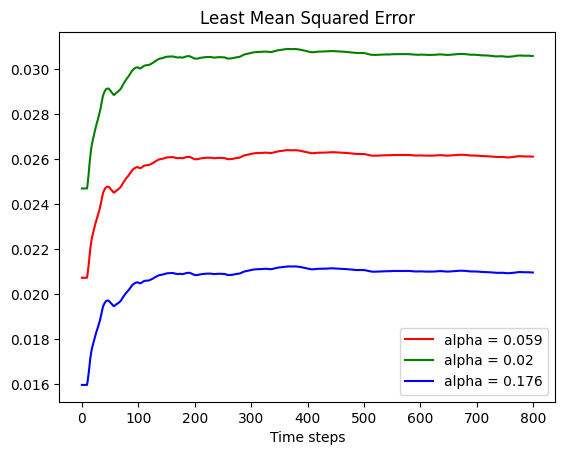

In [ ]:
error1 = []
y1 = np.zeros((10, 1))
for t in range(800):
  y1 = y1 + (shared_theta_estimate1 - estimated_theta[t])
  lse = ((np.linalg.norm(y1)))**2/(t+1)**2
  error1.append(lse)
print(len(error1))
error2 = []
y2 = np.zeros((10, 1))
for t in range(800):
  y2 = y2 + (shared_theta_estimate2 - estimated_theta[t])
  lse = ((np.linalg.norm(y2)))**2/(t+1)**2
  error2.append(lse)
print(len(error2))
error3 = []
y3 = np.zeros((10, 1))
for t in range(800):
  y3 = y3 + (shared_theta_estimate3 - estimated_theta[t])
  lse = ((np.linalg.norm(y3)))**2/(t+1)**2
  error3.append(lse)
print(len(error3))
plt.plot(error1, label="alpha = " + str(0.059), color = 'r')
plt.plot(error2, label="alpha = " + str(0.02), color = 'g')
plt.plot(error3, label="alpha = " + str(0.176), color = 'b')
# plt.plot(error, label="α = " + str(beta), color = 'g')
plt.legend()
plt.xlabel('Time steps')
plt.title("Least Mean Squared Error")
plt.show()
